In [277]:
# from google.colab import drive
# drive.mount('/content/drive')
# !pip install -r '/content/drive/MyDrive/Information Retrieval 1/hw2/requirements.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [278]:
cd '/content/drive/MyDrive/Information Retrieval 1/hw2'

/content/drive/MyDrive/Information Retrieval 1/hw2


# Homework 2: Learning to Rank <a class="anchor" id="toptop"></a>

**Submission instructions**:
- The cells with the `# YOUR CODE HERE` denote that these sections are graded and you need to add your implementation.
- Please use Python 3.6.5 and `pip install -r requirements.txt` to avoid version issues.
- The notebook you submit has to have the student ids, separated by underscores (E.g., `12341234_12341234_12341234_hw1.ipynb`).
- This will be parsed by a regexp, **so please double check your filename**.
- Only one member of each group has to submit the file (**please do not compress the .ipynb file when you will submit it**) to canvas.
- **Make sure to check that your notebook runs before submission**. A quick way to do this is to restart the kernel and run all the cells.  
- Do not change the number of arugments in the given functions.
- **Please do not delete/add new cells**. Removing cells **will** lead to grade deduction. 
- Note, that you are not allowed to use Google Colab.

**Learning Goals**:
- Offline LTR
  - Learn how to implement pointwise, pairwise and listwise algorithms for learning to rank 

---
**Recommended Reading**:
  - Chris Burges, Tal Shaked, Erin Renshaw, Ari Lazier, Matt Deeds, Nicole Hamilton, and Greg Hullender. Learning to rank using gradient descent. InProceedings of the 22nd international conference on Machine learning, pages 89–96, 2005.
  - Christopher J Burges, Robert Ragno, and Quoc V Le. Learning to rank with nonsmooth cost functions. In Advances inneural information processing systems, pages 193–200, 2007
  - (Sections 1, 2 and 4) Christopher JC Burges. From ranknet to lambdarank to lambdamart: An overview. Learning, 11(23-581):81, 2010
  

Additional Resources: 
- This assignment requires knowledge of [PyTorch](https://pytorch.org/). If you are unfamiliar with PyTorch, you can go over [these series of tutorials](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)

In the previous assignment, you experimented with retrieval with different ranking functions and in addition, different document representations. 

This assignment deals directly with learning to rank (LTR). In offline LTR, You will learn how to implement methods from the three approaches associated with learning to rank: pointwise, pairwise and listwise. 


**Note:**
  - The dataset used in this assignment is +100Mb in size. You may need around 2Gb of RAM for running the whole notebook.


# Table of Contents  <a class="anchor" id="top"></a>

[Back to top](#toptop)


Table of contents:


 - [Chapter 1: Offline LTR](#o_LTR) (270 points)
     - [Section 1: Dataset and Utility](#dataU) (- points)
     - [Section 2: Pointwtise LTR](#pointwiseLTR) (55 points)
     - [Section 3: Pairwise LTR](#pairwiseLTR) (35 points)
     - [Section 4: Pairwise Speed-up RankNet](#SpairwiseLTR) (65 points)
     - [Section 5: Listwise LTR](#listwiseLTR) (60 points)
     - [Section 6: Evaluation](#evaluation1) (55 points)

In [1]:
import os
import json
import itertools
from argparse import Namespace
from collections import OrderedDict
from functools import partial


import torch
import numpy as np
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from tqdm.notebook import tqdm, trange
from torch.utils.data import Dataset, DataLoader


import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import pandas as pd

import dataset
import evaluate

# Chapter 1: Offline LTR <a class="anchor" id="o_LTR"></a>

A typical setup of learning to rank involves a feature vector constructed using a query-document pair, and a set of relevance judgements. You are given a set of triples (`query`, `document`, `relevance grade`); where relevance grade is an *ordinal* variable  with  5  grades,  for example: {`perfect`,`excellent`,`good`,`fair`,`bad`),  typically  labeled  by human annotators.  

In this assignment, you are already given the feature vector for a given document and query pair. To access these vectors, see the following code cells (note: the dataset will be automatically downloaded & the first time the next cell runs, it will take a while!)

## Section 1: Data and Utility <a class="anchor" id="dataU"></a>

[Back to TOC](#top)

First let's get familiar with the dataset and some utility methods for our implementations.

### Section 1.1 Dataset stats

| Split Name | \# queries | \# docs | \# features |
| :- | :--: | :--: | :--: |
| train | 2735 | 85227 | 501 |
| validation | 403 | 12794 | 501 |
| test | 949 | 29881 | 501 |


In [2]:
dataset.download_dataset()
data = dataset.get_dataset()
# there is only 1 fold for this dataset 
data = data.get_data_folds()[0]
# read in the data
data.read_data()

In [3]:
print(f"Number of features: {data.num_features}")
# print some statistics
for split in ["train", "validation", "test"]:
    print(f"Split: {split}")
    split = getattr(data, split)
    print(f"\tNumber of queries {split.num_queries()}")
    print(f"\tNumber of docs {split.num_docs()}")

Number of features: 501
Split: train
	Number of queries 2735
	Number of docs 85227
Split: validation
	Number of queries 403
	Number of docs 12794
Split: test
	Number of queries 949
	Number of docs 29881


### Section 1.2 Utility classes/methods

The following cells contain code that will be useful for the assigment. 

In [4]:
# these is a useful class to create torch DataLoaders, and can be used during training
class LTRData(Dataset):
    def __init__(self, data, split):
        split = {
            "train": data.train,
            "validation": data.validation,
            "test": data.test
        }.get(split)
        assert split is not None, "Invalid split!"
        features, labels = split.feature_matrix, split.label_vector
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)
    
    def __len__(self):
        return self.features.size(0)

    def __getitem__(self, i):
        return self.features[i], self.labels[i]

In [5]:
## example 
train_dl = DataLoader(LTRData(data, "train"), batch_size=32, shuffle=True)
# this is how you would use it to quickly iterate over the train/val/test sets 
# - (of course, without the break statement!)
for (x, y) in train_dl:
    print(x.size(), y.size())
    break

torch.Size([32, 501]) torch.Size([32])


`evaluate_model` evaluates a model, on a given split.

In [6]:
# this function evaluates a model, on a given split
def evaluate_model(pred_fn, split, batch_size=256, print_results=False, q_level=False):
    dl = DataLoader(LTRData(data, split), batch_size=batch_size)
    all_scores = []
    all_labels = []
    for (x, y) in tqdm(dl, desc=f'Eval ({split})', leave=False):
        all_labels.append(y.squeeze().numpy())
        
        with torch.no_grad():
            output = pred_fn(x)
            all_scores.append(output.squeeze().numpy())
            
    split = {
            "train": data.train,
            "validation": data.validation,
            "test": data.test
    }.get(split)   
    results = evaluate.evaluate2(np.asarray(all_scores), np.asarray(all_labels), print_results=print_results, q_level=q_level)

    return results


In [7]:
## example 
# function that scores a given feature vector e.g a network
net = nn.Linear(501, 1)
# the evaluate method accepts a function. more specifically, a callable (such as pytorch modules) 
def notwork(x):
    return net(x)
# evaluate the function
_ = evaluate_model(notwork, "validation", print_results=True)

Eval (validation):   0%|          | 0/50 [00:00<?, ?it/s]

"metric": "mean" ("standard deviation")
dcg: 87.0228 (19.78846)
dcg@03: 4.9830 (2.58578)
dcg@05: 6.8425 (3.00639)
dcg@10: 10.9579 (4.69864)
dcg@20: 18.3522 (7.01030)
ndcg: 0.7031 (0.05656)
ndcg@03: 0.1849 (0.11675)
ndcg@05: 0.1961 (0.11371)
ndcg@10: 0.2268 (0.11827)
ndcg@20: 0.2815 (0.11370)
precision@01: 0.0200 (0.14000)
precision@03: 0.0933 (0.16384)
precision@05: 0.0880 (0.12106)
precision@10: 0.0980 (0.11746)
precision@20: 0.1320 (0.10477)
recall@01: 0.0004 (0.00250)
recall@03: 0.0126 (0.02718)
recall@05: 0.0194 (0.03074)
recall@10: 0.0412 (0.04892)
recall@20: 0.1143 (0.08817)
relevant rank: 103.6859 (67.38845)
relevant rank per query: 2449.0600 (1318.44329)


C:\Users\lcu1812\Anaconda3\envs\IR\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


The next cell is used to generate reproducible results:

In [8]:
# use to get reproducible results
def seed(random_seed):
    import random
    torch.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    

## Section 2: Pointwise LTR (55 points) <a class="anchor" id="pointwiseLTR"></a>

[Back to TOC](#top)

Let $x \in \mathbb{R}^d$ be an input feature vector, containing features for a query-document pair. Let $f: \mathbb{R}^d \rightarrow \mathbb{R} $ be a function that maps this feature vector to a number $f(x)$ - either a relevance score (regression) or label (classification). The data $\{x \}$ are treated as feature vectors and the relevance judgements are treated as the target which we want to predict. 

In this section, you will implement a simple Pointwise model using either a regression loss, and use the train set to train this model to predict the relevance score. 


### Section 2.1: Neural Model (25 points)

In the following cell, you will implement a simple pointwise LTR model: 
- Use a neural network to learn a model with different loss functions, using the relevance grades as the label. Use the following parameters: 
  - Layers: $501 (input) \rightarrow 256 \rightarrow 1$ where each layer is a linear layer (`nn.Linear`) with a ReLu activation function (`nn.ReLU`) in between the layers. Use the default weight initialization scheme. (Hint: use `nn.Sequential` for a one-line forward function!)
  - This network will also be used by other methods i.e Pairwise 
  
You should implement the following three methods:
- `__init__` (4 points)
- `forward` (1 point)



In [9]:
# TODO: Implement this! (5 points)
class NeuralModule(nn.Module):
    def __init__(self):
        """
        Initializes the Pointwise neural network.
        """
        
        # YOUR CODE HERE
        super(NeuralModule, self).__init__()
        self.input_size = 501
        self.batch_size = 256

        # self.model = nn.Sequential(
        #   nn.Linear(self.input_size, self.batch_size),
        #   nn.ReLU(),
        #   nn.Linear(self.batch_size, 1),
        #   nn.Softmax()
        # )

        self.model = nn.Sequential(
          nn.Linear(self.input_size, self.batch_size),
          nn.ReLU(),
          nn.Linear(self.batch_size, 1)
        )

        # self.model = nn.Sequential(
        #   nn.Linear(self.input_size, self.batch_size),
        #   nn.ReLU(),
        #   nn.Linear(self.batch_size, 1),
        #   nn.ReLU()
        # )
    
    def forward(self, x):
        """
        Takes in an input feature matrix of size (N, 501) and produces the output 
        Input: x: a [N, 501] tensor
        Output: a [N, 1] tensor
        """
        # YOUR CODE HERE
        return self.model(x)
        

In [10]:
# check the network configuration - layer dimensions and configurations
point_nn_reg = NeuralModule()
print(point_nn_reg)

NeuralModule(
  (model): Sequential(
    (0): Linear(in_features=501, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [11]:
# test the forward function
n = 10
inp = torch.rand(n, data.num_features)
out = point_nn_reg(inp)


In [12]:
print(inp.grad)
print(out)

None
tensor([[-0.1270],
        [ 0.0462],
        [-0.1215],
        [-0.0507],
        [-0.0992],
        [ 0.0577],
        [-0.0463],
        [-0.0739],
        [-0.1754],
        [-0.1270]], grad_fn=<AddmmBackward>)


**Implementation (20 points):**
Implement `train_batch` function to compute the gradients (`backward()` function) and update the weights (`step()` function), using the specified loss function.

In [13]:
# TODO: Implement this! (20 points)

def train_batch(net, x, y, loss_fn, optimizer):
    """
    Takes as input a batch of size N, i.e. feature matrix of size (N, 501), label vector of size (N), the loss function and optimizer for computing the gradients, 
    and updates the weights of the model.

    Input:  x: feature matrix, a [N, 501] tensor
            y: label vector, a [N] tensor
            loss_fn: an implementation of a loss function
            optimizer: an optimizer for computing the gradients (we use Adam)
    """
    # YOUR CODE HERE
    optimizer.zero_grad()
    scores = net(x)
    loss = loss_fn(scores, y)  # add requires_grad=True?
    net.zero_grad()  # not sure if this is necessary => Lan: i think maybe not
    loss.backward()
    optimizer.step()


In [14]:
# Please do not change this. This cell is used for grading.


\#### Please do not change this. This cell is used for grading.

### Section 2.2: Loss Functions (5 points)
Pointwise LTR algorithms use pointwise loss functions.
Usually, the popular loss functions for pointwise LTR is Regression loss.

**Implementation (5 points):**
Implement regression loss.

In [15]:
# TODO: Implement this! (5 points)
def pointwise_loss(output, target):
    """
    Regression loss - returns a single number. 
    Make sure to use the MSE loss
    output: (float) tensor, shape - [N, 1] 
    target: (float) tensor, shape - [N]. 
    """
    assert target.dim() == 1
    assert output.size(0) == target.size(0)
    assert output.size(1) == 1
    
    # YOUR CODE HERE
    target = target.view(1, -1)
    criterion = nn.MSELoss()
    loss = criterion(output, target)
    return loss


In [16]:
## Test pointwise_loss
g = torch.manual_seed(42)
output = [torch.randint(low=0, high=5, size=(5, 1), generator=g).float() for _ in range(5)]
target = torch.randint(low=0, high=5, size=(5,), generator=g).float()

l = [pointwise_loss(o, target).item() for o in output]
print(f'your results:{l}')


your results:[3.200000047683716, 6.360000133514404, 4.159999847412109, 5.400000095367432, 3.240000009536743]


C:\Users\lcu1812\Anaconda3\envs\IR\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


**Implementation (25 points):**
Now implement a wrapper for training a pointwise LTR, that takes the model as input and trains the model.

**Rubric:**
 - Network is trained for specified epochs, and iterates over the entire dataset and (train) data is shuffled : 5 points
 - Evaluation on the validation set: 5 points
 - Performance as expected: 15 points

In [17]:
# TODO: Implement this! (25 points)
def train_pointwise(net, params):
    """
    This function should train a Pointwise network. 
    
    The network is trained using the Adam optimizer
        
    
    Note: Do not change the function definition! 
    
    
    Hints:
    1. Use the LTRData class defined above
    2. Do not forget to use net.train() and net.eval()
    
    Inputs:
            net: the neural network to be trained

            params: params is an object which contains config used in training 
                (eg. params.epochs - the number of epochs to train). 
                For a full list of these params, see the next cell. 
    
    Returns: a dictionary containing: "metrics_val" (a list of dictionaries) and 
             "metrics_train" (a list of dictionaries). 
             
             "metrics_val" should contain metrics (the metrics in params.metrics) computed
             after each epoch on the validation set (metrics_train is similar). 
             You can use this to debug your models.
    
    """
    
    
    val_metrics_epoch = []
    train_metrics_epoch = []
    optimizer = Adam(net.parameters(), lr=params.lr)
    loss_fn = pointwise_loss
    
    # YOUR CODE HERE

    for i in range(params.epochs):
      train_dl = DataLoader(LTRData(data, "train"), batch_size=params.batch_size, shuffle=True)
      for (x, y) in train_dl:
        net.input_size = x.size()[1]
        net.batch_size = params.batch_size
        break

      for (x, y) in train_dl:
          train_batch(net, x, y, loss_fn, optimizer)

      train_metrics_epoch.append(evaluate_model(net, "train", print_results=True))

      # validation
      val_dl = DataLoader(LTRData(data, "validation"), batch_size=params.batch_size, shuffle=True)

      val_metrics_epoch.append(evaluate_model(net, "validation", print_results=True))
    
    return {
        "metrics_val": val_metrics_epoch,
        "metrics_train": train_metrics_epoch
    }

In [18]:
# Please do not change this. This cell is used for grading.

\#### Please do not change this. This cell is used for grading.

In [19]:
# Change this to test your code!
pointwise_test_params = Namespace(epochs=1, 
                    lr=1e-3,
                    batch_size=256,
                   metrics={"ndcg"})
# uncomment to test your code
# train a regression model
met_reg = train_pointwise(point_nn_reg, pointwise_test_params)


C:\Users\lcu1812\Anaconda3\envs\IR\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1, 256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\lcu1812\Anaconda3\envs\IR\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1, 235])) that is different to the input size (torch.Size([235, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Eval (train):   0%|          | 0/333 [00:00<?, ?it/s]

"metric": "mean" ("standard deviation")
dcg: 83.6733 (21.03172)
dcg@03: 4.0805 (4.17547)
dcg@05: 5.7025 (4.96535)
dcg@10: 9.0382 (6.34826)
dcg@20: 14.0212 (7.77490)
ndcg: 0.6740 (0.05841)
ndcg@03: 0.1473 (0.14558)
ndcg@05: 0.1569 (0.13074)
ndcg@10: 0.1806 (0.11675)
ndcg@20: 0.2120 (0.10233)
precision@01: 0.0661 (0.24840)
precision@03: 0.0931 (0.18360)
precision@05: 0.0919 (0.15214)
precision@10: 0.1021 (0.12362)
precision@20: 0.0986 (0.09359)
recall@01: 0.0024 (0.00992)
recall@03: 0.0139 (0.03215)
recall@05: 0.0210 (0.03745)
recall@10: 0.0459 (0.05894)
recall@20: 0.0850 (0.07657)
relevant rank: 120.6643 (71.68860)
relevant rank per query: 2866.5916 (1463.78646)


Eval (validation):   0%|          | 0/50 [00:00<?, ?it/s]

"metric": "mean" ("standard deviation")
dcg: 82.3997 (20.53910)
dcg@03: 3.2426 (3.01698)
dcg@05: 4.8089 (3.46959)
dcg@10: 7.8051 (4.04574)
dcg@20: 12.8030 (5.57928)
ndcg: 0.6618 (0.05791)
ndcg@03: 0.1162 (0.10613)
ndcg@05: 0.1303 (0.09037)
ndcg@10: 0.1550 (0.08083)
ndcg@20: 0.1922 (0.07724)
precision@01: 0.0800 (0.27129)
precision@03: 0.0533 (0.15434)
precision@05: 0.0600 (0.12806)
precision@10: 0.0720 (0.08256)
precision@20: 0.0840 (0.08452)
recall@01: 0.0021 (0.00741)
recall@03: 0.0042 (0.01321)
recall@05: 0.0116 (0.02484)
recall@10: 0.0323 (0.04138)
recall@20: 0.0700 (0.06175)
relevant rank: 120.9949 (72.06513)
relevant rank per query: 2857.9000 (1472.81523)


The next cell is used to generate results:

In [20]:

    
def create_results(net, train_fn, prediction_fn, *train_params):
    
    print("Training Model")
    metrics = train_fn(net, *train_params)
    net.eval()
    test_metrics, test_qq = evaluate_model(prediction_fn, "test", print_results=True, q_level=True)
    
    
    test_q = {}
    for m in {"ndcg", "precision@05", "recall@05"}:
        test_q[m] = test_qq[m]
    
    
    return {
        "metrics": metrics,
        "test_metrics": test_metrics,
        "test_query_level_metrics": test_q,
        }


Now use the above functions to generate your results:

In [21]:
seed(42)
params_regr = Namespace(epochs=11, 
                    lr=1e-3,
                    batch_size=256,
                    metrics={"ndcg", "precision@05", "recall@05"})

pointwise_regression_model = NeuralModule()
pw_regr = create_results(pointwise_regression_model, 
                          train_pointwise, 
                          pointwise_regression_model,
                          params_regr)

Training Model


Eval (train):   0%|          | 0/333 [00:00<?, ?it/s]

"metric": "mean" ("standard deviation")
dcg: 87.6884 (20.76704)
dcg@03: 5.9154 (4.68019)
dcg@05: 8.1565 (5.20717)
dcg@10: 12.2291 (6.24992)
dcg@20: 18.7541 (7.66434)
ndcg: 0.7081 (0.05587)
ndcg@03: 0.2199 (0.17480)
ndcg@05: 0.2290 (0.14949)
ndcg@10: 0.2492 (0.12651)
ndcg@20: 0.2870 (0.10587)
precision@01: 0.1682 (0.37402)
precision@03: 0.1572 (0.22145)
precision@05: 0.1604 (0.17430)
precision@10: 0.1471 (0.12956)
precision@20: 0.1462 (0.10161)
recall@01: 0.0082 (0.02373)
recall@03: 0.0216 (0.03523)
recall@05: 0.0373 (0.04551)
recall@10: 0.0679 (0.06329)
recall@20: 0.1301 (0.08611)
relevant rank: 105.7271 (70.91133)
relevant rank per query: 2511.7327 (1360.05899)


Eval (validation):   0%|          | 0/50 [00:00<?, ?it/s]

"metric": "mean" ("standard deviation")
dcg: 85.9730 (20.84005)
dcg@03: 4.3483 (3.72987)
dcg@05: 6.1761 (4.59519)
dcg@10: 10.1527 (5.07312)
dcg@20: 16.6332 (6.36849)
ndcg: 0.6916 (0.05844)
ndcg@03: 0.1577 (0.13644)
ndcg@05: 0.1684 (0.12798)
ndcg@10: 0.2017 (0.10473)
ndcg@20: 0.2513 (0.09526)
precision@01: 0.0800 (0.27129)
precision@03: 0.0667 (0.16330)
precision@05: 0.0840 (0.14472)
precision@10: 0.1020 (0.10098)
precision@20: 0.1170 (0.08866)
recall@01: 0.0032 (0.01085)
recall@03: 0.0088 (0.02125)
recall@05: 0.0171 (0.03215)
recall@10: 0.0423 (0.04047)
recall@20: 0.1019 (0.06999)
relevant rank: 105.3480 (70.62151)
relevant rank per query: 2488.3200 (1314.38955)


Eval (train):   0%|          | 0/333 [00:00<?, ?it/s]

"metric": "mean" ("standard deviation")
dcg: 87.4219 (20.48560)
dcg@03: 5.7192 (4.41381)
dcg@05: 7.8499 (5.11362)
dcg@10: 12.0139 (6.16269)
dcg@20: 18.5657 (7.34345)
ndcg: 0.7064 (0.05676)
ndcg@03: 0.2139 (0.17150)
ndcg@05: 0.2224 (0.15231)
ndcg@10: 0.2456 (0.12906)
ndcg@20: 0.2855 (0.10703)
precision@01: 0.1351 (0.34187)
precision@03: 0.1542 (0.23162)
precision@05: 0.1514 (0.18251)
precision@10: 0.1465 (0.13544)
precision@20: 0.1447 (0.10337)
recall@01: 0.0068 (0.02263)
recall@03: 0.0216 (0.03824)
recall@05: 0.0344 (0.04555)
recall@10: 0.0662 (0.06597)
recall@20: 0.1276 (0.08798)
relevant rank: 106.7682 (70.98944)
relevant rank per query: 2536.4655 (1395.71578)


Eval (validation):   0%|          | 0/50 [00:00<?, ?it/s]

"metric": "mean" ("standard deviation")
dcg: 86.2562 (20.81515)
dcg@03: 5.0361 (4.34146)
dcg@05: 7.0730 (4.97449)
dcg@10: 10.9543 (5.98617)
dcg@20: 17.0124 (7.35729)
ndcg: 0.6947 (0.05970)
ndcg@03: 0.1838 (0.17245)
ndcg@05: 0.1979 (0.15867)
ndcg@10: 0.2218 (0.13268)
ndcg@20: 0.2582 (0.11349)
precision@01: 0.1600 (0.36661)
precision@03: 0.1000 (0.17951)
precision@05: 0.1080 (0.15600)
precision@10: 0.1160 (0.11723)
precision@20: 0.1210 (0.10397)
recall@01: 0.0068 (0.01761)
recall@03: 0.0113 (0.02098)
recall@05: 0.0225 (0.03230)
recall@10: 0.0510 (0.05085)
recall@20: 0.1015 (0.07432)
relevant rank: 106.2396 (71.00438)
relevant rank per query: 2509.3800 (1285.74067)


Eval (train):   0%|          | 0/333 [00:00<?, ?it/s]

"metric": "mean" ("standard deviation")
dcg: 80.5085 (19.79949)
dcg@03: 2.8082 (2.86798)
dcg@05: 4.0725 (3.57232)
dcg@10: 6.5368 (4.35988)
dcg@20: 10.5406 (5.48173)
ndcg: 0.6490 (0.05431)
ndcg@03: 0.1020 (0.10021)
ndcg@05: 0.1128 (0.09647)
ndcg@10: 0.1324 (0.08698)
ndcg@20: 0.1618 (0.08067)
precision@01: 0.0541 (0.22612)
precision@03: 0.0561 (0.14218)
precision@05: 0.0565 (0.11571)
precision@10: 0.0619 (0.08605)
precision@20: 0.0631 (0.07019)
recall@01: 0.0022 (0.01003)
recall@03: 0.0068 (0.01925)
recall@05: 0.0131 (0.03243)
recall@10: 0.0271 (0.04346)
recall@20: 0.0539 (0.06123)
relevant rank: 135.8634 (71.21381)
relevant rank per query: 3227.6727 (1588.93839)


Eval (validation):   0%|          | 0/50 [00:00<?, ?it/s]

"metric": "mean" ("standard deviation")
dcg: 79.7365 (19.95414)
dcg@03: 3.0288 (3.17210)
dcg@05: 3.9859 (3.44657)
dcg@10: 6.0371 (3.80348)
dcg@20: 9.9539 (4.98129)
ndcg: 0.6401 (0.05442)
ndcg@03: 0.1107 (0.12474)
ndcg@05: 0.1100 (0.10013)
ndcg@10: 0.1186 (0.07163)
ndcg@20: 0.1473 (0.06610)
precision@01: 0.0600 (0.23749)
precision@03: 0.0533 (0.16813)
precision@05: 0.0440 (0.10800)
precision@10: 0.0420 (0.07236)
precision@20: 0.0450 (0.04924)
recall@01: 0.0022 (0.00874)
recall@03: 0.0059 (0.01834)
recall@05: 0.0078 (0.01925)
recall@10: 0.0167 (0.03084)
recall@20: 0.0346 (0.03622)
relevant rank: 133.9941 (70.36165)
relevant rank per query: 3164.9400 (1512.17649)


Eval (train):   0%|          | 0/333 [00:00<?, ?it/s]

"metric": "mean" ("standard deviation")
dcg: 84.7366 (20.71337)
dcg@03: 4.5446 (4.26907)
dcg@05: 6.3436 (4.97889)
dcg@10: 10.0384 (6.04700)
dcg@20: 15.6396 (7.51946)
ndcg: 0.6833 (0.05794)
ndcg@03: 0.1654 (0.15438)
ndcg@05: 0.1763 (0.13803)
ndcg@10: 0.2028 (0.11867)
ndcg@20: 0.2385 (0.10467)
precision@01: 0.1081 (0.31052)
precision@03: 0.1211 (0.21693)
precision@05: 0.1201 (0.16617)
precision@10: 0.1216 (0.12283)
precision@20: 0.1159 (0.09642)
recall@01: 0.0056 (0.02302)
recall@03: 0.0175 (0.03951)
recall@05: 0.0273 (0.04448)
recall@10: 0.0547 (0.05922)
recall@20: 0.1027 (0.08009)
relevant rank: 117.1470 (72.92602)
relevant rank per query: 2783.0330 (1442.75487)


Eval (validation):   0%|          | 0/50 [00:00<?, ?it/s]

"metric": "mean" ("standard deviation")
dcg: 84.1099 (20.48391)
dcg@03: 4.2316 (3.78893)
dcg@05: 6.0337 (4.92721)
dcg@10: 9.6146 (6.03892)
dcg@20: 14.9999 (6.84857)
ndcg: 0.6764 (0.05003)
ndcg@03: 0.1495 (0.13199)
ndcg@05: 0.1621 (0.12874)
ndcg@10: 0.1876 (0.11153)
ndcg@20: 0.2231 (0.08913)
precision@01: 0.1000 (0.30000)
precision@03: 0.0933 (0.17689)
precision@05: 0.1040 (0.17545)
precision@10: 0.1040 (0.11655)
precision@20: 0.1090 (0.08043)
recall@01: 0.0034 (0.01071)
recall@03: 0.0108 (0.02139)
recall@05: 0.0222 (0.04082)
recall@10: 0.0481 (0.06455)
recall@20: 0.1027 (0.08304)
relevant rank: 114.6706 (72.60833)
relevant rank per query: 2708.5200 (1388.04090)


Eval (train):   0%|          | 0/333 [00:00<?, ?it/s]

"metric": "mean" ("standard deviation")
dcg: 87.1830 (20.84038)
dcg@03: 5.8873 (4.90269)
dcg@05: 8.0819 (5.51300)
dcg@10: 12.2082 (6.64365)
dcg@20: 18.4505 (7.89588)
ndcg: 0.7038 (0.05881)
ndcg@03: 0.2159 (0.17694)
ndcg@05: 0.2258 (0.15427)
ndcg@10: 0.2479 (0.13298)
ndcg@20: 0.2821 (0.11061)
precision@01: 0.1562 (0.36300)
precision@03: 0.1642 (0.24455)
precision@05: 0.1610 (0.18738)
precision@10: 0.1498 (0.14028)
precision@20: 0.1428 (0.10735)
recall@01: 0.0080 (0.02502)
recall@03: 0.0237 (0.04399)
recall@05: 0.0378 (0.05149)
recall@10: 0.0687 (0.06609)
recall@20: 0.1249 (0.08715)
relevant rank: 108.6184 (72.31338)
relevant rank per query: 2580.4204 (1367.56703)


Eval (validation):   0%|          | 0/50 [00:00<?, ?it/s]

"metric": "mean" ("standard deviation")
dcg: 86.8319 (22.00724)
dcg@03: 5.2795 (5.62539)
dcg@05: 7.3309 (7.10031)
dcg@10: 11.4262 (7.82950)
dcg@20: 19.0270 (9.20521)
ndcg: 0.6977 (0.05615)
ndcg@03: 0.1835 (0.18324)
ndcg@05: 0.1930 (0.17250)
ndcg@10: 0.2216 (0.13465)
ndcg@20: 0.2826 (0.11122)
precision@01: 0.1600 (0.36661)
precision@03: 0.1267 (0.23935)
precision@05: 0.1280 (0.21821)
precision@10: 0.1300 (0.14731)
precision@20: 0.1570 (0.11576)
recall@01: 0.0058 (0.01386)
recall@03: 0.0140 (0.02782)
recall@05: 0.0237 (0.03937)
recall@10: 0.0565 (0.05863)
recall@20: 0.1438 (0.09432)
relevant rank: 105.4149 (73.10083)
relevant rank per query: 2489.9000 (1256.29543)


Eval (train):   0%|          | 0/333 [00:00<?, ?it/s]

"metric": "mean" ("standard deviation")
dcg: 84.0976 (20.55484)
dcg@03: 4.3654 (4.38088)
dcg@05: 6.0779 (4.88126)
dcg@10: 9.5755 (5.96587)
dcg@20: 14.5565 (7.24336)
ndcg: 0.6782 (0.05940)
ndcg@03: 0.1588 (0.15825)
ndcg@05: 0.1686 (0.13578)
ndcg@10: 0.1939 (0.12093)
ndcg@20: 0.2230 (0.10692)
precision@01: 0.1051 (0.30669)
precision@03: 0.1091 (0.20611)
precision@05: 0.1039 (0.15543)
precision@10: 0.1123 (0.12423)
precision@20: 0.1035 (0.09233)
recall@01: 0.0048 (0.01847)
recall@03: 0.0155 (0.03381)
recall@05: 0.0241 (0.04331)
recall@10: 0.0513 (0.06386)
recall@20: 0.0904 (0.08095)
relevant rank: 119.2629 (72.10088)
relevant rank per query: 2833.3003 (1471.52252)


Eval (validation):   0%|          | 0/50 [00:00<?, ?it/s]

"metric": "mean" ("standard deviation")
dcg: 83.4049 (19.81294)
dcg@03: 4.0973 (3.51192)
dcg@05: 5.8239 (4.26784)
dcg@10: 9.2137 (5.15327)
dcg@20: 14.3957 (6.30420)
ndcg: 0.6713 (0.05051)
ndcg@03: 0.1426 (0.11810)
ndcg@05: 0.1551 (0.11154)
ndcg@10: 0.1810 (0.10018)
ndcg@20: 0.2155 (0.09031)
precision@01: 0.0800 (0.27129)
precision@03: 0.1067 (0.21541)
precision@05: 0.1000 (0.16613)
precision@10: 0.1020 (0.11915)
precision@20: 0.1040 (0.08052)
recall@01: 0.0034 (0.01159)
recall@03: 0.0139 (0.02983)
recall@05: 0.0248 (0.04648)
recall@10: 0.0485 (0.06333)
recall@20: 0.0988 (0.08037)
relevant rank: 117.4691 (71.85685)
relevant rank per query: 2774.6200 (1427.91698)


Eval (train):   0%|          | 0/333 [00:00<?, ?it/s]

"metric": "mean" ("standard deviation")
dcg: 83.5114 (20.12472)
dcg@03: 4.2308 (3.86481)
dcg@05: 5.8591 (4.35687)
dcg@10: 9.0362 (5.49093)
dcg@20: 13.9011 (6.77866)
ndcg: 0.6740 (0.05746)
ndcg@03: 0.1563 (0.14320)
ndcg@05: 0.1658 (0.12782)
ndcg@10: 0.1841 (0.11345)
ndcg@20: 0.2137 (0.10137)
precision@01: 0.1021 (0.30278)
precision@03: 0.0961 (0.19531)
precision@05: 0.1003 (0.15077)
precision@10: 0.0970 (0.11724)
precision@20: 0.0932 (0.09008)
recall@01: 0.0055 (0.02400)
recall@03: 0.0133 (0.03151)
recall@05: 0.0236 (0.04192)
recall@10: 0.0433 (0.05685)
recall@20: 0.0807 (0.07820)
relevant rank: 123.4663 (72.19505)
relevant rank per query: 2933.1592 (1511.48672)


Eval (validation):   0%|          | 0/50 [00:00<?, ?it/s]

"metric": "mean" ("standard deviation")
dcg: 82.9595 (20.12108)
dcg@03: 4.5007 (3.56780)
dcg@05: 5.6888 (3.68297)
dcg@10: 8.7526 (4.78655)
dcg@20: 14.0299 (6.32093)
ndcg: 0.6671 (0.05161)
ndcg@03: 0.1583 (0.13801)
ndcg@05: 0.1541 (0.11135)
ndcg@10: 0.1726 (0.09429)
ndcg@20: 0.2104 (0.09147)
precision@01: 0.1200 (0.32496)
precision@03: 0.1400 (0.24120)
precision@05: 0.0920 (0.15078)
precision@10: 0.0800 (0.10392)
precision@20: 0.0980 (0.08244)
recall@01: 0.0048 (0.01314)
recall@03: 0.0164 (0.02976)
recall@05: 0.0185 (0.03439)
recall@10: 0.0340 (0.04883)
recall@20: 0.0837 (0.07253)
relevant rank: 121.2320 (71.73991)
relevant rank per query: 2863.5000 (1389.41448)


Eval (train):   0%|          | 0/333 [00:00<?, ?it/s]

"metric": "mean" ("standard deviation")
dcg: 85.5951 (20.70887)
dcg@03: 5.2105 (4.71551)
dcg@05: 7.0753 (5.19300)
dcg@10: 10.8399 (6.50777)
dcg@20: 16.4337 (7.80569)
ndcg: 0.6906 (0.05937)
ndcg@03: 0.1910 (0.16961)
ndcg@05: 0.1975 (0.14308)
ndcg@10: 0.2192 (0.12768)
ndcg@20: 0.2514 (0.11175)
precision@01: 0.1351 (0.34187)
precision@03: 0.1291 (0.22299)
precision@05: 0.1273 (0.17016)
precision@10: 0.1249 (0.13382)
precision@20: 0.1182 (0.09891)
recall@01: 0.0066 (0.02175)
recall@03: 0.0187 (0.03992)
recall@05: 0.0297 (0.04643)
recall@10: 0.0555 (0.06332)
recall@20: 0.1040 (0.08771)
relevant rank: 115.4322 (72.68402)
relevant rank per query: 2742.2943 (1426.50488)


Eval (validation):   0%|          | 0/50 [00:00<?, ?it/s]

"metric": "mean" ("standard deviation")
dcg: 85.1734 (20.86679)
dcg@03: 4.8169 (4.39131)
dcg@05: 6.5748 (4.89965)
dcg@10: 10.4293 (6.20890)
dcg@20: 16.4659 (7.61918)
ndcg: 0.6851 (0.05559)
ndcg@03: 0.1673 (0.14831)
ndcg@05: 0.1740 (0.12448)
ndcg@10: 0.2046 (0.11592)
ndcg@20: 0.2469 (0.10397)
precision@01: 0.1400 (0.34699)
precision@03: 0.1133 (0.21715)
precision@05: 0.1000 (0.14560)
precision@10: 0.1140 (0.12002)
precision@20: 0.1250 (0.09233)
recall@01: 0.0074 (0.02133)
recall@03: 0.0149 (0.02947)
recall@05: 0.0256 (0.04497)
recall@10: 0.0543 (0.06708)
recall@20: 0.1176 (0.09197)
relevant rank: 111.6113 (71.82545)
relevant rank per query: 2636.2600 (1336.42366)


Eval (train):   0%|          | 0/333 [00:00<?, ?it/s]

"metric": "mean" ("standard deviation")
dcg: 86.3687 (20.42950)
dcg@03: 5.5780 (4.35120)
dcg@05: 7.4512 (4.94640)
dcg@10: 11.3984 (5.96238)
dcg@20: 17.2352 (7.18765)
ndcg: 0.6976 (0.05823)
ndcg@03: 0.2063 (0.16047)
ndcg@05: 0.2110 (0.14632)
ndcg@10: 0.2337 (0.12632)
ndcg@20: 0.2658 (0.10848)
precision@01: 0.1351 (0.34187)
precision@03: 0.1491 (0.21945)
precision@05: 0.1375 (0.18060)
precision@10: 0.1360 (0.13850)
precision@20: 0.1255 (0.10116)
recall@01: 0.0064 (0.02006)
recall@03: 0.0209 (0.03559)
recall@05: 0.0318 (0.04691)
recall@10: 0.0600 (0.06212)
recall@20: 0.1097 (0.08625)
relevant rank: 111.6792 (72.10509)
relevant rank per query: 2653.1351 (1414.32050)


Eval (validation):   0%|          | 0/50 [00:00<?, ?it/s]

"metric": "mean" ("standard deviation")
dcg: 85.9481 (20.57088)
dcg@03: 4.9928 (3.58117)
dcg@05: 7.0943 (4.40530)
dcg@10: 11.0466 (5.52568)
dcg@20: 17.4520 (7.27757)
ndcg: 0.6920 (0.05161)
ndcg@03: 0.1805 (0.14298)
ndcg@05: 0.1978 (0.13960)
ndcg@10: 0.2208 (0.11849)
ndcg@20: 0.2616 (0.10089)
precision@01: 0.1800 (0.38419)
precision@03: 0.1133 (0.18391)
precision@05: 0.1200 (0.15492)
precision@10: 0.1280 (0.12812)
precision@20: 0.1240 (0.09394)
recall@01: 0.0065 (0.01429)
recall@03: 0.0120 (0.01944)
recall@05: 0.0252 (0.03346)
recall@10: 0.0578 (0.06277)
recall@20: 0.1105 (0.08224)
relevant rank: 109.9678 (72.74771)
relevant rank per query: 2597.4400 (1366.23962)


Eval (train):   0%|          | 0/333 [00:00<?, ?it/s]

"metric": "mean" ("standard deviation")
dcg: 87.6131 (20.82767)
dcg@03: 6.0406 (4.82210)
dcg@05: 8.4117 (5.48882)
dcg@10: 12.3806 (6.52944)
dcg@20: 18.7335 (7.64361)
ndcg: 0.7075 (0.05883)
ndcg@03: 0.2237 (0.17893)
ndcg@05: 0.2369 (0.15675)
ndcg@10: 0.2531 (0.13456)
ndcg@20: 0.2876 (0.11134)
precision@01: 0.1682 (0.37402)
precision@03: 0.1672 (0.23482)
precision@05: 0.1694 (0.19084)
precision@10: 0.1532 (0.13938)
precision@20: 0.1444 (0.10299)
recall@01: 0.0085 (0.02551)
recall@03: 0.0223 (0.03543)
recall@05: 0.0391 (0.04981)
recall@10: 0.0684 (0.06536)
recall@20: 0.1271 (0.08553)
relevant rank: 106.2009 (71.86960)
relevant rank per query: 2522.9880 (1361.91079)


Eval (validation):   0%|          | 0/50 [00:00<?, ?it/s]

"metric": "mean" ("standard deviation")
dcg: 87.4001 (20.08681)
dcg@03: 6.3166 (4.69734)
dcg@05: 8.5473 (5.39032)
dcg@10: 12.3985 (5.61695)
dcg@20: 19.5195 (7.39034)
ndcg: 0.7051 (0.05218)
ndcg@03: 0.2258 (0.17084)
ndcg@05: 0.2327 (0.15338)
ndcg@10: 0.2478 (0.12285)
ndcg@20: 0.2936 (0.10917)
precision@01: 0.2000 (0.40000)
precision@03: 0.1533 (0.20232)
precision@05: 0.1560 (0.15641)
precision@10: 0.1460 (0.12035)
precision@20: 0.1510 (0.10653)
recall@01: 0.0100 (0.02289)
recall@03: 0.0237 (0.03411)
recall@05: 0.0395 (0.04897)
recall@10: 0.0668 (0.05689)
recall@20: 0.1339 (0.08805)
relevant rank: 105.8552 (72.52301)
relevant rank per query: 2500.3000 (1312.07265)


Eval (train):   0%|          | 0/333 [00:00<?, ?it/s]

"metric": "mean" ("standard deviation")
dcg: 87.9466 (21.23779)
dcg@03: 6.3259 (5.40883)
dcg@05: 8.5546 (5.98348)
dcg@10: 12.9180 (7.01506)
dcg@20: 19.3295 (8.39612)
ndcg: 0.7096 (0.05927)
ndcg@03: 0.2304 (0.19069)
ndcg@05: 0.2371 (0.16150)
ndcg@10: 0.2604 (0.13610)
ndcg@20: 0.2946 (0.11648)
precision@01: 0.1922 (0.39402)
precision@03: 0.1862 (0.25449)
precision@05: 0.1748 (0.20051)
precision@10: 0.1652 (0.14010)
precision@20: 0.1538 (0.10867)
recall@01: 0.0091 (0.02568)
recall@03: 0.0268 (0.04386)
recall@05: 0.0401 (0.05118)
recall@10: 0.0751 (0.06664)
recall@20: 0.1349 (0.09059)
relevant rank: 105.3908 (72.38662)
relevant rank per query: 2503.7447 (1337.17682)


Eval (validation):   0%|          | 0/50 [00:00<?, ?it/s]

"metric": "mean" ("standard deviation")
dcg: 87.6349 (21.25735)
dcg@03: 6.9059 (6.14486)
dcg@05: 9.1315 (6.83678)
dcg@10: 12.9486 (7.53471)
dcg@20: 19.2844 (9.21252)
ndcg: 0.7056 (0.05521)
ndcg@03: 0.2372 (0.20274)
ndcg@05: 0.2411 (0.17379)
ndcg@10: 0.2531 (0.14205)
ndcg@20: 0.2867 (0.12056)
precision@01: 0.2000 (0.40000)
precision@03: 0.1933 (0.25897)
precision@05: 0.1840 (0.21850)
precision@10: 0.1460 (0.13448)
precision@20: 0.1440 (0.11603)
recall@01: 0.0112 (0.02643)
recall@03: 0.0304 (0.04960)
recall@05: 0.0419 (0.05410)
recall@10: 0.0681 (0.07116)
recall@20: 0.1231 (0.08134)
relevant rank: 105.3641 (72.48283)
relevant rank per query: 2488.7000 (1242.87969)


Eval (test):   0%|          | 0/117 [00:00<?, ?it/s]

"metric": "mean" ("standard deviation")
dcg: 91.5237 (19.95419)
dcg@03: 5.9796 (5.13690)
dcg@05: 8.0646 (5.62469)
dcg@10: 12.2020 (6.20981)
dcg@20: 18.8128 (7.31521)
ndcg: 0.7076 (0.05221)
ndcg@03: 0.2131 (0.18543)
ndcg@05: 0.2174 (0.15247)
ndcg@10: 0.2384 (0.11516)
ndcg@20: 0.2790 (0.09887)
precision@01: 0.1709 (0.37646)
precision@03: 0.1510 (0.22852)
precision@05: 0.1368 (0.16672)
precision@10: 0.1342 (0.11259)
precision@20: 0.1423 (0.09190)
recall@01: 0.0077 (0.01869)
recall@03: 0.0205 (0.03398)
recall@05: 0.0307 (0.04566)
recall@10: 0.0562 (0.05457)
recall@20: 0.1139 (0.07329)
relevant rank: 109.4135 (71.59997)
relevant rank per query: 2815.7607 (1384.14820)


In [22]:
assert "test_metrics" in pw_regr.keys()
assert "ndcg" in pw_regr["test_metrics"].keys()
assert "precision@05" in pw_regr["test_metrics"].keys()
assert "recall@05" in pw_regr["test_metrics"].keys()

## Section 3: Pairwise LTR (35 points) <a class="anchor" id="pairwiseLTR"></a>

[Back to TOC](#top)

In this section,  you will learn and implement RankNet, a  pairwise learning to rank algorithm.

For a given query, consider two documents $D_i$ and $D_j$ with two different ground truth relevance  labels,  with  feature  vectors $x_i$ and $x_j$ respectively.   The  RankNet  model,  just  like  the pointwise model, uses $f$ to predict scores i.e $s_i=f(x_i)$ and $s_j=f(x_j)$, but uses a different loss during  training. $D_i \triangleright D_j$ denotes  the  event  that $D_i$ should  be  ranked  higher  than $D_j$.   The  two outputs $s_i$ and $s_j$ are mapped to a learned probability that $D_i \triangleright D_j$: 


$$        P_{ij} = \frac{1}{1 + e^{-\sigma(s_i - s_j)}} $$
  
where $\sigma$ is a parameter that determines the shape of the sigmoid. The loss of the RankNet model is the cross entropy cost function:

$$        C = - \bar{P}_{ij} \log P_{ij} - (1-\bar{P}_{ij}) \log (1 - P_{ij}) $$

As the name suggests, in the pairwise approach to LTR, we optimize a loss $l$ over pairs of documents. Let $S_{ij} \in \{0, \pm1 \}$ be equal to $1$ if the relevance of document $i$ is greater than document $j$; $-1$ if document $j$ is more relevant than document $i$; and 0 if they have the same relevance. This gives us $\bar{P}_{ij} = \frac{1}{2} (1 + S_{ij})$ so that $\bar{P}_{ij} = 1$ if $D_i \triangleright D_j$; $\bar{P}_{ij} = 0$ if $D_j \triangleright D_i$; and finally $\bar{P}_{ij} = \frac{1}{2}$ if the relevance is identical. This gives us:

$$        C = \frac{1}{2}(1- S_{ij})\sigma(s_i - s_j) + \log(1+ e^{-\sigma(s_i - s_j)}) $$

Now, consider a single query for which $n$ documents have been returned. Let the output scores of the ranker be $s_j$ ; $j=\{1, \dots, n \}$, the model parameters be $w_k \in \mathbb{R}^W$, and let the set of pairs of document indices used for training be $\mathcal{P}$. Then, the total cost is $C_T = \sum_{i,j \in \mathcal{P}} C(s_i; s_j)$. 



- Implement RankNet. You should construct training samples by creating all possible pairs of documents for a given query and optimizing the loss above. Use the following parameters:
  - Layers: $501 (input) \rightarrow 256 \rightarrow 1$, where each layer is a linear layer (`nn.Linear`) with a ReLu activation function (`nn.ReLu`) in between the layers. Use the default weight initialization scheme. (Hint: use `nn.Sequential` for a one-line forward function!)

For the pairwise loss, we need to have a structured **dataloader** which detects the documents associated with a specific query:

In [23]:
class QueryGroupedLTRData(Dataset):
    def __init__(self, data, split):
        self.split = {
            "train": data.train,
            "validation": data.validation,
            "test": data.test
        }.get(split)
        assert self.split is not None, "Invalid split!"
    
    def __len__(self):
        return self.split.num_queries()

    def __getitem__(self, q_i):
        feature = torch.FloatTensor(self.split.query_feat(q_i))
        labels = torch.FloatTensor(self.split.query_labels(q_i))
        return feature, labels

    
## example
train_data = QueryGroupedLTRData(data, "train")
# this is how you would use it to quickly iterate over the train/val/test sets 

q_i = 300
features_i, labels_i = train_data[q_i]
print(f"Query {q_i} has {len(features_i)} query-document pairs")
print(f"Shape of features for Query {q_i}: {features_i.size()}")
print(f"Shape of labels for Query {q_i}: {labels_i.size()}")
        

Query 300 has 57 query-document pairs
Shape of features for Query 300: torch.Size([57, 501])
Shape of labels for Query 300: torch.Size([57])


**Implementation (35 points):**
First, implement the pairwaise loss, described above.

**Rubric:**
 - Each ordering <i,j> combination is considered: 10 points
 - Proper application of the formula: 10 points
 - Mean loss: 5 points
 - Loss values for test cases as expected: 10 points

In [24]:
# TODO: Implement this! (35 points)
def pairwise_loss(scores, labels):
    """
    Compute and return the pairwise loss *for a single query*. To compute this, compute the loss for each 
    ordering in a query, and then return the mean. Use sigma=1.
    
    For a query, consider all possible ways of comparing 2 document-query pairs.
    
    Hint: See the next cell for an example which should make it clear how the inputs look like
    
    scores: tensor of size [N, 1] (the output of a neural network), where N = length of <query, document> pairs
    labels: tensor of size [N], contains the relevance labels 
    """
        
    
    
    # if there's only one rating
    if labels.size(0) < 2:
        return None
    
    count = 0
    # C_list = []
    C_matrix = torch.zeros([len(scores), len(scores)])
    S_ij = {}
    for i_index, i_label  in enumerate(labels):
        for j_index, j_label in enumerate(labels):
            if i_label>j_label:
                S_ij[(i_index,j_index)] = 1
            if i_label<j_label:
                S_ij[(i_index,j_index)] = -1
            if i_label==j_label:
                S_ij[(i_index,j_index)]= 0
    for x in range(len(scores)):
        for y in range(len(scores)):
            if x != y:
                C = ((0.5)*(1-S_ij[x,y])*(scores[x]-scores[y]))+np.log(1+np.exp(-1*(scores[x]-scores[y])))
                # C_list.append(C)
                C_matrix[x, y] = C
                count+=1

                
    
    # mean = sum(C_list)/len(C_list)
    mean_matrix = C_matrix.sum()/count
    
    return mean_matrix
    

In [25]:
# Please do not change this. This cell is used for grading.

\#### Please do not change this. This cell is used for grading.

In [26]:
scores_1 = torch.FloatTensor([0.2, 2.3, 4.5, 0.2, 1.0]).unsqueeze(1)
labels_1 = torch.FloatTensor([1, 2, 3, 0, 4])


scores_2 = torch.FloatTensor([3.2, 1.7]).unsqueeze(1)
labels_2 = torch.FloatTensor([3, 1])

assert torch.allclose(pairwise_loss(scores_1, labels_1), torch.tensor(0.6869), atol=1e-03)
assert torch.allclose(pairwise_loss(scores_2, labels_2), torch.tensor(0.2014), atol=1e-03)


## Section 4: Pairwise: Speed-up RankNet (65 points) <a class="anchor" id="SpairwiseLTR"></a>

[Back to TOC](#top)

To speed up training of the previous model, we can consider a sped up version of the model, where instead of `.backward` on the loss, we use `torch.backward(lambda_i)`. 

The derivative of the total cost $C_T$ with respect to the model parameters $w_k$ is:

$$        \frac{\partial C_T}{\partial w_k} = \sum_{(i,j) \in \mathcal{P}} \frac{\partial C(s_i, s_j)}{\partial s_i} \frac{\partial s_i}{\partial w_k} + \frac{\partial C(s_i, s_j)}{\partial s_j} \frac{\partial s_j}{\partial w_k} $$

We can rewrite this sum by considering the set of indices $j$ , for which $\{i,j\}$ is a valid pair, denoted by $\mathcal{P}_i$, and the set of document indices $\mathcal{D}$:

$$
\frac{\partial C_T}{\partial w_k} = \sum_{i \in \mathcal{D}}
\frac{\partial s_i}{\partial w_k} \sum_{j \in \mathcal{P}_i} 
\frac{\partial C(s_i, s_j)}{\partial s_i} 
$$

This sped of version of the algorithm first computes scores $s_i$ for all the documents. Then for each $j= 1, \dots, n$, compute:

$$
\lambda_{ij} = \frac{\partial C(s_i, s_j)}{\partial s_i} = \sigma \bigg( \frac{1}{2}(1 - S_{ij}) -  \frac{1}{1 + e^{\sigma(s_i -s_j))}} \bigg) \\
\lambda_i = \sum_{j \in \mathcal{P}_i} \frac{\partial C(s_i, s_j)}{\partial s_i} = \sum_{j \in \mathcal{P}_i} \lambda_{ij}
$$

That gives us:

$$
\frac{\partial C_T}{\partial w_k} = \sum_{i \in \mathcal{D}}
\frac{\partial s_i}{\partial w_k} \lambda_i
$$

This can be directly optimized in pytorch using: `torch.autograd.backward(scores, lambda_i)` 
 


**Implementation (50 points):**
Implement the sped-up version of pairwise loss, described above.

**Rubric:**
 - Each ordering <i,j> combination is considered: 15 points
 - Proper application of the formula: 15 points
 - Loss values for test cases as expected: 20 points

In [27]:
# TODO: Implement this! (50 points)
def compute_lambda_i(scores, labels):
    """
    Compute \lambda_i (defined in the previous cell). (assume sigma=1.)
    
    scores: tensor of size [N, 1] (the output of a neural network), where N = length of <query, document> pairs
    labels: tensor of size [N], contains the relevance labels 
    
    return: \lambda_i, a tensor of shape: [N, 1]
    """
        
    # YOUR CODE HERE
    N = len(labels)
    labels = labels[None, :]
    sij = labels.T - labels
    sij[sij<-1] = -1
    sij[sij>1] = 1
    diff_scores = scores - scores.T

    part1 = torch.exp(diff_scores)
    part2 = part1.add(1)
    part3 = 1 / part2

    part4 = 1 - sij
    part5 = 0.5 * part4

    lambda_i_j = part5 - part3

    lambda_i = torch.sum(lambda_i_j, 1)
    lambda_i = torch.reshape(lambda_i, (N, 1))
    
    return lambda_i

In [28]:
# Please do not change this. This cell is used for grading.

\#### Please do not change this. This cell is used for grading.

In [29]:
def mean_lambda(scores, labels):
    return torch.stack([compute_lambda_i(scores, labels).mean(), torch.square(compute_lambda_i(scores, labels)).mean()])

scores_1 = torch.FloatTensor([10.2, 0.3, 4.5, 2.0, -1.0]).unsqueeze(1)
labels_1 = torch.FloatTensor([1, 2, 3, 0, 4])

assert torch.allclose(mean_lambda(scores_1, labels_1), torch.tensor([0,5.5072]), atol=1e-03)

scores_2 = torch.FloatTensor([3.2, 1.7]).unsqueeze(1)
labels_2 = torch.FloatTensor([3, 1])

assert torch.allclose(mean_lambda(scores_2, labels_2), torch.tensor([0,3.3279e-02]), atol=1e-03)



**Implementation (15 points):**
Implement `train_batch_vector` function to compute the gradients (`torch.autograd.backward(scores, lambda_i)` function) and update the weights (`step()` function), using the specified loss function.

In [30]:
# TODO: Implement this! (15 points)

def train_batch_vector(net, x, y, loss_fn, optimizer):
    """
    Takes as input a batch of size N, i.e. feature matrix of size (N, 501), label vector of size (N), the loss function and optimizer for computing the gradients, and updates the weights of the model.
    The loss function returns a vector of size [N, 1], the same as the output of network.

    Input:  x: feature matrix, a [N, 501] tensor
            y: label vector, a [N] tensor
            loss_fn: an implementation of a loss function
            optimizer: an optimizer for computing the gradients (we use Adam)
    """
    # YOUR CODE HERE
    optimizer.zero_grad()
    scores = net(x)
    loss = loss_fn(scores, y)
    loss = torch.tensor(loss, requires_grad=True)
    torch.autograd.backward(scores, loss)
    optimizer.step()

In [31]:
# Please do not change this. This cell is used for grading.

\#### Please do not change this. This cell is used for grading.

##  Section 5: Listwise LTR (60 points) <a class="anchor" id="listwiseLTR"></a>

[Back to TOC](#top)

In this section, you will implement LambdaRank, a listwise approach to LTR. Consider the computation of $\lambda$ for sped-up RankNet (that you've already implemented). $\lambda$ here amounts to the 'force' on a document given its neighbours in the ranked list. The design of $\lambda$ in LambdaRank is similar to RankNet, but is scaled by DCG gain from swapping the two documents in question. Let's suppose that the corresponding ranks of doucment $D_i$ and $D_j$ are $r_i$ and $r_j$ respectively. Given a ranking measure $IRM$, such as $NDCG$ or $ERR$, the lambda function in LambdaRank is defined as:


$$        \frac{\partial C}{\partial s_i} = \sum_{j \in D} \lambda_{ij} \cdot |\bigtriangleup IRM (i,j)| $$

Where $|\bigtriangleup IRM(i,j)|$ is the absolute difference in $IRM$ after swapping the rank positions $r_i$ and $r_j$ while leaving everything else unchanged ($| \cdot |$ denotes the absolute value). Note that we do not backpropogate $|\bigtriangleup IRM|$, it is treated as a constant that scales the gradients. In this assignment we will use $|\bigtriangleup NDCG|$

**Implementation (60 points):**
Implement the listwise loss.

**Rubric:**
 - Each ordering <i,j> combination is considered: 15 points
 - Computing $|\bigtriangleup NDCG|$: 15 points 
 - Proper application of the formula: 15 points 
 - Loss values as expected: 15 points

In [32]:
# TODO: Implement this! (60 points)
def listwise_loss(scores, labels):
    
    """
    Compute the LambdaRank loss. (assume sigma=1.)
    
    scores: tensor of size [N, 1] (the output of a neural network), where N = length of <query, document> pairs
    labels: tensor of size [N], contains the relevance labels 
    
    returns: a tensor of size [N, 1]
    """
    N = len(labels)
    labels = labels[None, :]
    sij = labels.T - labels
    sij[sij<-1] = -1
    sij[sij>1] = 1
    diff_scores = scores - scores.T

    part1 = torch.exp(diff_scores)
    part2 = part1.add(1)
    part3 = 1 / part2

    part4 = 1 - sij
    part5 = 0.5 * part4

    lambda_i_j = part5 - part3
    ideal_labels = labels.sort(descending=True)[0][:].squeeze()

    final = lambda_i_j * get_delta_ndcg(ideal_labels, labels, gpu=False)

    final = torch.sum(final,1)
    final = torch.reshape(final,(N,1))

    return final

In [33]:
def torch_ideal_dcg(batch_sorted_labels, gpu=False):
	'''
	:param sorted_labels: [batch, ranking_size]
	:return: [batch, 1]
	'''
	batch_gains = torch.pow(2.0, batch_sorted_labels) - 1.0
	batch_ranks = torch.arange(len(batch_sorted_labels))

	batch_discounts =  torch.log2(2.0 + batch_ranks.type(torch.FloatTensor))
	batch_ideal_dcg = torch.sum(batch_gains / batch_discounts)

	return batch_ideal_dcg

def get_delta_ndcg(batch_stds, batch_stds_sorted_via_preds, gpu):
    '''
    Delta-nDCG w.r.t. pairwise swapping of the currently predicted ltr_adhoc
    :param batch_stds: the standard labels sorted in a descending order
    :param batch_stds_sorted_via_preds: the standard labels sorted based on the corresponding predictions
    :return:
    '''
    batch_idcgs = torch_ideal_dcg(batch_sorted_labels=batch_stds, gpu=gpu)                      # ideal discount cumulative gains
    batch_gains = torch.pow(2.0, batch_stds_sorted_via_preds) - 1.0
    batch_n_gains = batch_gains / batch_idcgs
    batch_ng_diffs = torch.unsqueeze(batch_n_gains, dim=2) - torch.unsqueeze(batch_n_gains, dim=1)

    batch_std_ranks = torch.arange(len(batch_stds))
    batch_dists = 1.0 / torch.log2(batch_std_ranks + 2.0)   # discount co-efficients
    batch_dists = torch.unsqueeze(batch_dists, dim=0)
    batch_dists_diffs = torch.unsqueeze(batch_dists, dim=2) - torch.unsqueeze(batch_dists, dim=1)
    batch_delta_ndcg = torch.abs(batch_ng_diffs) * torch.abs(batch_dists_diffs)  # absolute changes w.r.t. pairwise swapping
    return batch_delta_ndcg

In [34]:
def mean_lambda_list(scores, labels):
    return torch.stack([listwise_loss(scores, labels).mean(), torch.square(listwise_loss(scores, labels)).mean()])


scores_1 = torch.FloatTensor([10.2, 0.3, 4.5, 2.0, -1.0]).unsqueeze(1)
labels_1 = torch.FloatTensor([1, 2, 3, 0, 4])
# assert torch.allclose(mean_lambda_list(scores_1, labels_1), torch.tensor([0,0.1391]), atol=1e-03)

scores_2 = torch.FloatTensor([3.2, 1.7]).unsqueeze(1)
labels_2 = torch.FloatTensor([3, 1])
assert torch.allclose(mean_lambda_list(scores_2, labels_2), torch.tensor([0,2.8024e-03]), atol=1e-03)


\#### Please do not change this. This cell is used for grading.

In [35]:
def mean_lambda_list(scores, labels):
    print(torch.square(listwise_loss(scores, labels)).mean())
    return torch.stack([listwise_loss(scores, labels).mean(), torch.square(listwise_loss(scores, labels)).mean()])

scores_1 = torch.FloatTensor([10.2, 0.3, 4.5, 2.0, -1.0]).unsqueeze(1)
labels_1 = torch.FloatTensor([1, 2, 3, 0, 4])
# assert torch.allclose(mean_lambda_list(scores_1, labels_1), torch.tensor([0,0.1336]), atol=1e-03)

scores_2 = torch.FloatTensor([3.2, 1.7]).unsqueeze(1)
labels_2 = torch.FloatTensor([3, 1])
assert torch.allclose(mean_lambda_list(scores_2, labels_2), torch.tensor([0,2.8024e-03]), atol=1e-03)

tensor(0.0028)


## Section 6: Comparing Pointwise, Pairwise and Listwise (55 points) <a class="anchor" id="evaluation1"></a>

[Back to TOC](#top)

In the next few cells, we will compare the methods you've implemented. Helper functions are provided for you, which you can use to make some conclusions. You can modify the code as needed!

First, let's have a function that plots the average scores of relevant (levels 3 and 4) and non-relevant (levels 0, 1, and 2) scores in terms of training epochs for different loss functions:

In [36]:
loss_functions = {'pointwise':[pointwise_loss, train_batch],
                 'pairwise':[compute_lambda_i, train_batch_vector],
                 'listwise':[listwise_loss, train_batch_vector]}

def plot_relevance_scores(batches, loss_function):
    seed(420)
    net = NeuralModule()
    optimizer = Adam(net.parameters(), lr=0.005)
    loss_fn = loss_functions[loss_function][0]
    train_fn = loss_functions[loss_function][1]
    
    
    train_batchs = batches[:len(batches)*3//4]
    test_batchs = batches[len(batches)*3//4:]
    
    rel, nrel = [], []
    
    for i in range(100):
        r, n = [], []

        for x, y in test_batchs:
            binary_rel = np.round(y/4,0)
            scores = net(x)[:,0]
            r.append(torch.sum(scores * binary_rel).detach().numpy() / torch.sum(binary_rel).detach().numpy())
            n.append(torch.sum(scores * (1. - binary_rel)).detach().numpy() / torch.sum((1. - binary_rel)).detach().numpy())
            
            
        for x, y in train_batchs:
            train_fn(net, x, y, loss_fn, optimizer)
        rel.append(np.mean(np.array(r)))
        nrel.append(np.mean(np.array(n)))
        
    
        
    plt.figure()
    plt.suptitle(loss_function)
    plt.plot(np.arange(10,len(rel)), rel[10:], label='relevant')
    plt.plot(np.arange(10,len(nrel)), nrel[10:], label='non-relevant')
    plt.legend()
    
        

For efficiency issues, we select a small number (83) of queries to test different loss functions.
We split these queries into train and test with a 3:1 ratio.

In [37]:
batches = [train_data[i] for i in [181, 209, 233, 242, 259, 273, 327, 333, 377, 393, 410, 434, 452, 503, 529, 573, 581, 597, 625, 658, 683, 724, 756, 757, 801, 825, 826, 828, 874, 902, 1581, 1588, 1636, 1691, 1712, 1755, 1813, 1983, 2001, 2018, 2021, 2024, 2029, 2065, 2095, 2100, 2171, 2172, 2174, 2252, 2274, 2286, 2288, 2293, 2297, 2353, 2362, 2364, 2365, 2368, 2400, 2403, 2433, 2434, 2453, 2472, 2529, 2534, 2539, 2543, 2555, 2576, 2600, 2608, 2636, 2641, 2653, 2692, 2714, 2717, 2718, 2723, 2724]]

Next, we train a neural network with different loss functions on the selected queries.
During training, we save the average scores of relevant and non-relevant validation items for each training epoch and plot them as follows:

C:\Users\lcu1812\Anaconda3\envs\IR\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


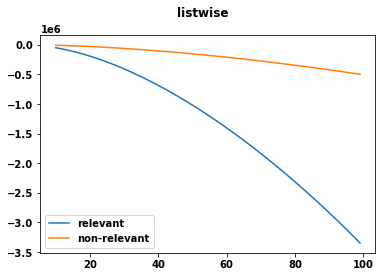

In [38]:
plot_relevance_scores(batches, 'listwise')

C:\Users\lcu1812\Anaconda3\envs\IR\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1, 40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\lcu1812\Anaconda3\envs\IR\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1, 42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\lcu1812\Anaconda3\envs\IR\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1, 33])) that is different to the input size (torch.Size([33, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

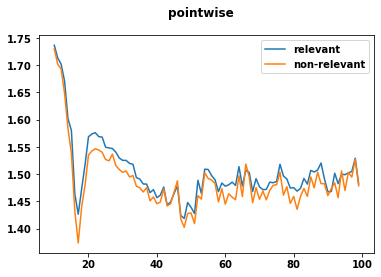

In [39]:

plot_relevance_scores(batches, 'pointwise')



C:\Users\lcu1812\Anaconda3\envs\IR\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


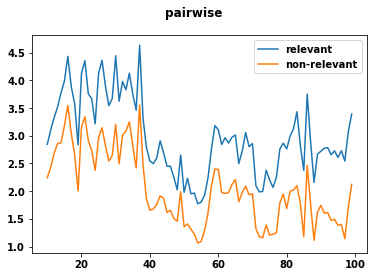

In [40]:
plot_relevance_scores(batches, 'pairwise')


**Implementation (15 points):**
Now implement a function similar to `plot_relevance_scores` that measures the NDCG@10 on the test split with different loss functions.
Train your model for 10 epochs.
For NDCG@10 use `evaluate.ndcg10(scores.detach().numpy(), y.detach().numpy())` for each query and average through all queries to obtain NDCG@10 for each loss function at each epoch.

In [41]:
# TODO: Implement this! (15 points)


def plot_ndcg10(batches, loss_function):
    seed(420)
    net = NeuralModule()
    optimizer = Adam(net.parameters(), lr=0.005)
    loss_fn = loss_functions[loss_function][0]
    train_fn = loss_functions[loss_function][1]
        
    train_batchs = batches[:len(batches)*3//4]
    test_batchs = batches[len(batches)*3//4:]
    
    ndcg = []
    
    # YOUR CODE HERE
    
    for i in range(10):
        batch_ndcg = []

        for x, y in test_batchs:
            scores = net(x)[:,0]
            batch_ndcg.append(evaluate.ndcg10(scores.detach().numpy(), y.detach().numpy()))
            
        for x, y in train_batchs:
            train_fn(net, x, y, loss_fn, optimizer)
        ndcg.append(np.mean(batch_ndcg))
        
    
        
    plt.figure()
    plt.suptitle(loss_function)
    plt.plot(np.arange(len(ndcg)), ndcg, label=loss_function)
    plt.legend()
    
        
    


In [42]:
# Please do not change this. This cell is used for grading.

\#### Please do not change this. This cell is used for grading.

C:\Users\lcu1812\Anaconda3\envs\IR\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1, 40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\lcu1812\Anaconda3\envs\IR\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1, 42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\lcu1812\Anaconda3\envs\IR\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1, 33])) that is different to the input size (torch.Size([33, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure the

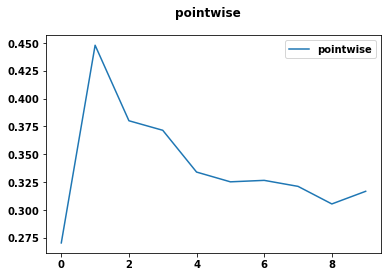

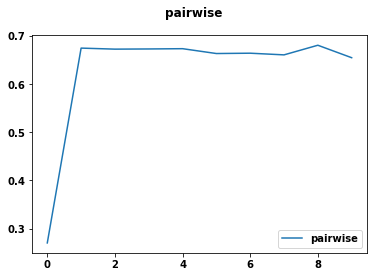

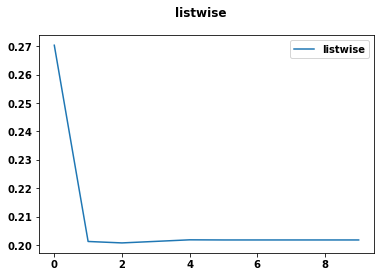

In [43]:
plot_ndcg10(batches, 'pointwise')

plot_ndcg10(batches, 'pairwise')

plot_ndcg10(batches, 'listwise')

Write a conclusion in the next cell, considering (40 points):
- rates of convergence
- time complexity
- distinguishing relevant and non-relevant items
- performance for low data wrt NDCG@10
- performance across queries
- ... any other observations

YOUR ANSWER HERE

## Pointwise
### rate of convergence
The network does not converge using the pointwise loss function. Reasons for this may be, in order of  descending likelihood: 
- incorrect implementation
- Using regression for a non-regression problem
- insufficient model complexity (i.e. not enough layers, not wide enough layers
- insufficient data
- bad quality of data

## time complexity
